# Heat content (HC) in the Labrador Sea (LSEA)

In [2]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

### Load datasets

#### HadOBS EN4

In [3]:
en4 = xr.open_dataset('/mnt/efs/data/temperature.nc')

#### Area

In [4]:
nc = xr.open_dataset('/mnt/efs/data/hadobs_en4_area.nc')
en4['area'] = nc.area
en4.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [5]:
south = 47
north = 75
west = -65
east = -20

tstart = '1990-01-01'
tend = '2017-12-31'

## Heat content
The heat content for each grid point is estimated as
$$ H = \rho\,c_p\int_{-D}^\eta \theta \, dz $$

$$ H_{SPNA} =  \rho\,c_p\oint \int_{-D}^\eta \theta \, dz\; dA = \rho\,c_p\iiint \theta\; dV $$

In [6]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

In [7]:
D = 700

In [8]:
temp = en4.temperature.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east),
                           depth=slice(0,D))-273.15

In [9]:
depth_bnds = en4.depth_bnds.sel(depth=slice(0,D))

In [10]:
print('D = ',depth_bnds[-1].values[-1],'m')

D =  725.1709 m


In [11]:
# Layer thickness
dz = (depth_bnds[:,1]-depth_bnds[:,0])

# Volume
vol = dz*en4.area.sel(lat=slice(south,north),lon=slice(west,east))

### Integrate over LSEA

#### Define regions: Subpolar North Atlantic (`lsea`)

In [14]:
boundary_coords = np.loadtxt('/mnt/efs/data/labrador_sea_boundary.txt')

In [15]:
# Replace each pair of points by 10 points for projected map
geometry = []
segments = zip(boundary_coords[:-1,0], boundary_coords[:-1,1],
               boundary_coords[1:,0], boundary_coords[1:,1])

for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
    for length in np.linspace(0,1,11):
        geometry.append( line.interpolate(length, normalized=True) )
        
gdf_patch = gpd.GeoDataFrame([], geometry=geometry)

# Convert Points to Polygon
gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])

gdf_patch['shape_id'] = 0
gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()

gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')

# Salem uses this attribute:
gdf_patch.crs = {'init': 'epsg:4326'}

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


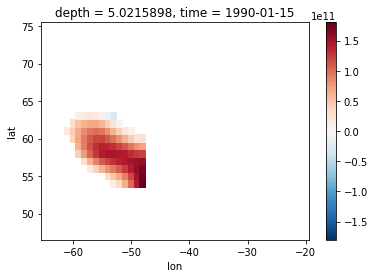

In [20]:
(temp*vol).salem.roi(shape=gdf_patch.loc[[0]])[0][0].plot()

In [21]:
# Heat content (J)
ohc = (temp*vol).salem.roi(shape=gdf_patch.loc[[0]]).sum(dim=['depth','lat','lon'])*rhoconst*c_p

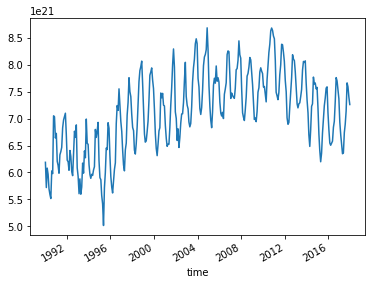

In [22]:
ohc.plot()

In [23]:
ohc_anom = ohc - ohc.mean('time')
#ohc_anom = ohc.groupby('time.month') - ohc.groupby('time.month').mean('time')

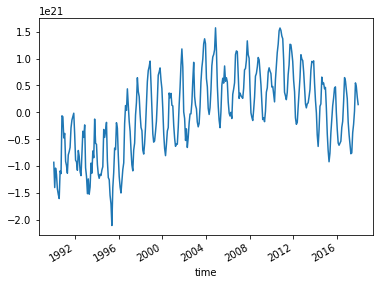

In [24]:
ohc_anom.plot()

In [19]:
ds = ohc_anom.to_dataset(name='ohc')
ds.time.attrs = []

In [20]:
ds.to_netcdf('/mnt/efs/data/hadobs_en4_hc_spna_upper700m_monthly.nc', format='NETCDF4',
             encoding={'ohc':   {'zlib': True}})

In [25]:
df = ohc_anom.to_dataframe(name='ohc')

In [26]:
# Save with index column (time)
df.to_csv('/mnt/efs/data/hadobs_en4_hc_lsea_upper700m_monthly.csv', index=True)